In [1]:
from pathlib import Path
import numpy as np
from skimage import io
from skimage.transform import rescale, resize
from scipy.ndimage import gaussian_filter
from scipy import ndimage

imginfo = lambda img: print(type(img), img.dtype, img.shape, img.min(), img.max())

In [2]:
# === load first touch coors
import json
with open("data/single_log.json") as f:
    episode_log = json.load(f)
first_x, first_y, first_z = map(int, episode_log["first_touch"])
cropw = 200

def to_batch(image):
    downscaled = resize(image, (224, 224))
    batch = torch.from_numpy(downscaled)[None, :, :, :].to(torch.float32) / 255  # [h, w, c] -> [1, h, w, c]
    batch = batch.permute(0, 3, 1, 2)  # [1, h, w, c] -> [1, c, h, w]
    return batch

def cut_crop(image):
    """
    :param image: [h, w, c]
    """
    return image[first_y-cropw:first_y+cropw, first_x-cropw:first_x+cropw]

In [3]:
# === Load last image before max
file_list = sorted(Path("data/frames").glob("center*jpg"))
print(len(file_list))

8


In [4]:
import numpy as np
import cv2 as cv

def read_gray(path):
    image = cv.imread(path)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    return gray

def plot_keypoints(gray):
    # Initiate ORB detector
    orb = cv.ORB_create()
     
    # find the keypoints with ORB
    kp = orb.detect(gray,None)
    print(len(kp))
     
    # compute the descriptors with ORB
    kp, des = orb.compute(gray, kp)
     
    # draw only keypoints location,not size and orientation
    canvas = cv.drawKeypoints(gray, kp, None, color=(0,255,0), flags=0)
    return canvas

def plot_sift(gray):
    sift = cv.SIFT_create()
    kp = sift.detect(gray,None)
    img=cv.drawKeypoints(gray,kp,None, color=(0,255,0), flags=0)
    return img

for i in range(len(file_list)):
    gray = read_gray(file_list[i])
    img = plot_keypoints(gray)
    cv.imwrite(f'data/k1_{i:0>2}.jpg',img)

500
500
500
500
500
500
500
500


In [5]:
print(len(file_list))
before = read_gray(file_list[0]).astype(np.float32)
grip = read_gray("data/frames/grip_image.jpg").astype(np.float32)
after = read_gray(file_list[-1]).astype(np.float32)
imginfo(before)

8
<class 'numpy.ndarray'> float32 (720, 1280) 0.0 255.0


In [6]:
# === Simple difference
def compute_diff(im1, im2):
    diff = im1 - im2
    #diff = np.sum(diff ** 2, axis=2)
    return diff

def scale(diff_image: np.array):
    low, high = np.quantile(diff_image, 0.1), np.quantile(diff_image, 0.99)
    return np.clip(diff_image / high * 255, 0, 255)

In [7]:
io.imsave("data/crop_1.jpg", resize(cut_crop(before), (cropw, cropw)).astype(np.uint8))
io.imsave("data/crop_2.jpg", resize(cut_crop(grip), (cropw, cropw)).astype(np.uint8))
io.imsave("data/crop_3.jpg", resize(cut_crop(after), (cropw, cropw)).astype(np.uint8))

diff1 = compute_diff(cut_crop(before), cut_crop(grip))
io.imsave("data/diff_1.jpg", resize(scale(diff1), (400, 400)).astype(np.uint8))

diff2 = compute_diff(cut_crop(after), cut_crop(grip))
io.imsave("data/diff_2.jpg", resize(scale(diff2), (400, 400)).astype(np.uint8))

In [46]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T

In [56]:
before = io.imread(file_list[0]).astype(np.float32)
grip = io.imread("data/frames/grip_image.jpg").astype(np.float32)
after = io.imread(file_list[5]).astype(np.float32) # [h, w, c]

before = cut_crop(before)
grip = cut_crop(grip)
after = cut_crop(after)

In [57]:
def to_batch(image):
    batch = torch.from_numpy(image)[None, :, :, :].to(torch.float32) / 255  # [h, w, c] -> [1, h, w, c]
    batch = batch.permute(0, 3, 1, 2)  # [1, h, w, c] -> [1, c, h, w]
    
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
            #T.Resize(size=(520, 960)),
        ]
    )
    batch = transforms(batch)
    return batch

img1_batch = to_batch(grip)
img2_batch = to_batch(after)
imginfo(img1_batch)

<class 'torch.Tensor'> torch.float32 torch.Size([1, 3, 400, 400]) tensor(-1.) tensor(1.)


In [49]:
from torchvision.models.optical_flow import raft_large

device = "cpu"
model = raft_large(pretrained=True, progress=False).to(device)
model = model.eval()

In [58]:
with torch.no_grad():
    list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

type = <class 'list'>
length = 12 = number of iterations of the model


In [59]:
imginfo(list_of_flows[-1])
predicted_flows = list_of_flows[-1].detach()

<class 'torch.Tensor'> torch.float32 torch.Size([1, 2, 400, 400]) tensor(-28.8606) tensor(2.1038)


In [60]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]


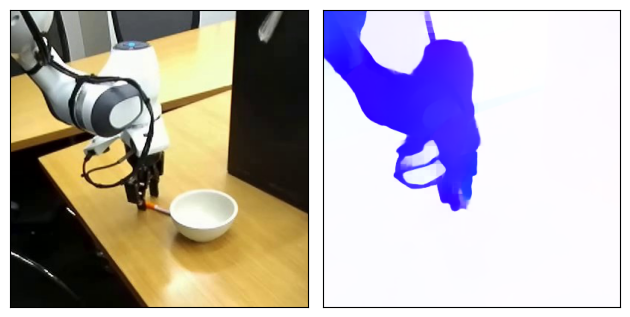

In [61]:
def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

plot(grid)

In [62]:
img = grid[0][0]
img = (img.to("cpu").permute([1, 2, 0]).numpy() * 255).astype(np.uint8)
io.imsave("data/raft_img.jpg", img)

img = grid[0][1]
img = (img.to("cpu").permute([1, 2, 0]).numpy() * 255).astype(np.uint8)
io.imsave("data/raft_flow.jpg", img)

